In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import collections
from matplotlib.pyplot import show
import sys
sys.path.append('..')


# our code (mark it at autoreload at every cell execution - useful in developement mode)
%load_ext autoreload
%autoreload 1
%aimport study_utils
%aimport lausanne_2016_utils

In [2]:
PATH_TO_DATA = '../../Scraping/DataSport/Data/Lausanne_Marathon_2016.pickle'

# Data wrangling

In this first part, we retrieve data of Lausanne Marathon 2016 and we manipulate the different columns in order to exploit them during the analysis part.

First, we use the pickle format to allow faster import of the data, and correct formatting of some columns as date columns.

Note: Same data are also available in CSV (readable format).

In [3]:
lausanne_marathon_2016 = pd.read_pickle(PATH_TO_DATA)
lausanne_marathon_2016.head()

,birthday,name,rank,time,number,team,acode,category
0,1976-01-01 00:00:00,Waardenburg George,285.0,1900-01-01 00:50:26.600000,11404,NaN,CPQP6ZGUB,10-H40
1,1997-01-01 00:00:00,Waeber Jean,186.0,1900-01-01 00:53:10.800000,13468,NaN,X4HC5EYRT,10-JunG
2,1963-01-01 00:00:00,Waeber Marie-Jo,17.0,1900-01-01 00:48:47.500000,11449,NaN,HAP8H6A7Q,10-D50
3,1979-01-01 00:00:00,Waeber Pascal,778.0,1900-01-01 02:03:58.500000,6523,NaN,ZT9BYS5M3,21-H30
4,1970-01-01 00:00:00,Waeber Yvette,11.0,1900-01-01 01:34:50.700000,6441,NaN,2T9WCSAM7,21-D40


Some participants are part of categories which must be excluded as these categories are not representative or can be misleading for the analysis part.

In [4]:
lausanne_marathon_2016_cleaned = lausanne_marathon_2016[lausanne_marathon_2016.apply(study_utils.filter_participants, axis=1)].copy()

Here, we know the categories of the runners and these categories contains sex information about the participants (for a given type of running, we have two subcategories for male and female runners, as usual in such sports). Thus, we use this information to create a new column giving the sex of each participants.

In [5]:
lausanne_marathon_2016_cleaned['sex'] = lausanne_marathon_2016_cleaned.apply(study_utils.get_sex_of_runner, axis=1)

In [6]:
lausanne_marathon_2016_cleaned['sex'].value_counts(dropna=False)

male      6801
female    4447
Name: sex, dtype: int64

In [7]:
len(lausanne_marathon_2016_cleaned)

11248

At the end of this stage, we have a total of 11248 runners on whom we can run our analysis for Lausanne Marathon 2016.

We also extract from the category the fact that a runner is either junior or adult.

In [8]:
lausanne_marathon_2016_cleaned['type'] = lausanne_marathon_2016_cleaned.apply(study_utils.get_type_of_runner, axis=1)

We also transform the *number* and *rank* columns, as they contain integer.

In [9]:
lausanne_marathon_2016_cleaned['number'] = lausanne_marathon_2016_cleaned['number'].apply(lambda x : int(float(x)))

In [10]:
lausanne_marathon_2016_cleaned['rank'] = lausanne_marathon_2016_cleaned['rank'].apply(lambda x : int(float(x)))

In [11]:
lausanne_marathon_2016_cleaned.head()

,birthday,name,rank,time,number,team,acode,category,sex,type
0,1976-01-01 00:00:00,Waardenburg George,285,1900-01-01 00:50:26.600000,11404,NaN,CPQP6ZGUB,10-H40,male,adult
1,1997-01-01 00:00:00,Waeber Jean,186,1900-01-01 00:53:10.800000,13468,NaN,X4HC5EYRT,10-JunG,male,junior
2,1963-01-01 00:00:00,Waeber Marie-Jo,17,1900-01-01 00:48:47.500000,11449,NaN,HAP8H6A7Q,10-D50,female,adult
3,1979-01-01 00:00:00,Waeber Pascal,778,1900-01-01 02:03:58.500000,6523,NaN,ZT9BYS5M3,21-H30,male,adult
4,1970-01-01 00:00:00,Waeber Yvette,11,1900-01-01 01:34:50.700000,6441,NaN,2T9WCSAM7,21-D40,female,adult


We also compute the age of runner based on the birthyear, to easily manipulate such information later.

In [12]:
lausanne_marathon_2016_cleaned['age'] = lausanne_marathon_2016_cleaned.apply(study_utils.compute_age_of_runner, axis=1)
lausanne_marathon_2016_cleaned['age'] = lausanne_marathon_2016_cleaned['age'].apply(lambda x : int(float(x)))

In [13]:
lausanne_marathon_2016_cleaned['age category'] = pd.cut(lausanne_marathon_2016_cleaned['age'], [15, 26, 31, 36, 41, 46, 51, 56, 61, 66, 100], labels=['15-25 years', '26-30 years', '31-35 years', '36-40 years', '41-45 years', '46-50 years', '51-55 years', '56-60 years', '61-65 years', '65+ years'], right=False)

If the time is in readable-format, it is difficult to use it this way for analysis as comparison can be misleading. For this reason, we decide to store time in raw format (i.e. number of seconds, without any format).

In [14]:
lausanne_marathon_2016_cleaned['time'] = lausanne_marathon_2016_cleaned.apply(study_utils.format_time, axis=1)

Moreover, we store the type of running the participants did.

In [15]:
lausanne_marathon_2016_cleaned['distance (km)'] = lausanne_marathon_2016_cleaned.apply(study_utils.compute_distance_from_category, axis=1)

We also need to compute the speed by kilometer for each runners.

In [16]:
lausanne_marathon_2016_cleaned['Speed (m/s)'] = lausanne_marathon_2016_cleaned['distance (km)']*1000/lausanne_marathon_2016_cleaned['time']
lausanne_marathon_2016_cleaned['type_team'] = lausanne_marathon_2016_cleaned.apply(study_utils.compute_run_in_team, axis=1)

Finally, we make three distinct sets of data (10 km, semi-marathon and marathon).

In [17]:
lausanne_marathon_2016_10km = lausanne_marathon_2016_cleaned[lausanne_marathon_2016_cleaned['distance (km)'] == 10]
lausanne_marathon_2016_21km = lausanne_marathon_2016_cleaned[lausanne_marathon_2016_cleaned['distance (km)'] == 21]
lausanne_marathon_2016_42km = lausanne_marathon_2016_cleaned[lausanne_marathon_2016_cleaned['distance (km)'] == 42]

In [18]:
lausanne_marathon_2016_cleaned.to_pickle('./Data/Lausanne_Marathon_2016_cleaned.pickle')

# Complete study

## Overall study

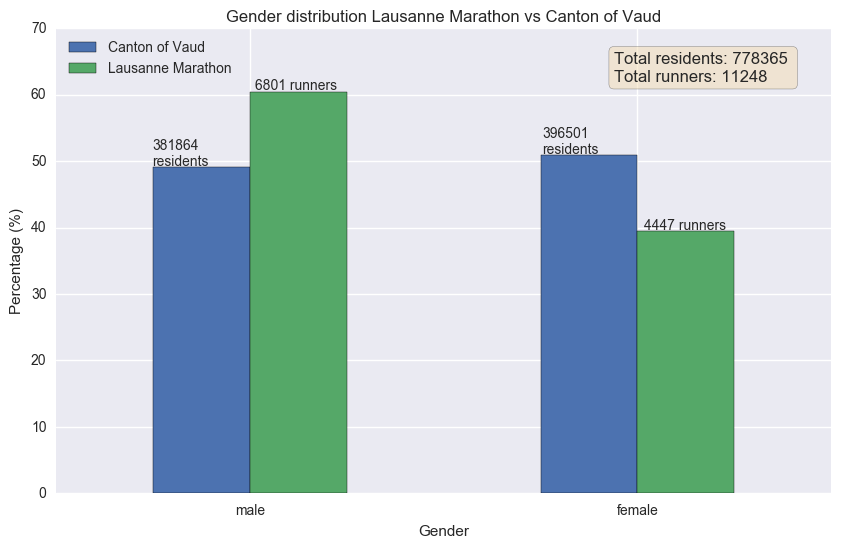

In [19]:
lausanne_2016_utils.plot_gender_distributions(lausanne_marathon_2016_cleaned)

As we can see, Lausanne Marathon race had a significantly higher percentage of male runners than female ones comparing to gender distribution of Canton of Vaud, which is equal regarding male and female.

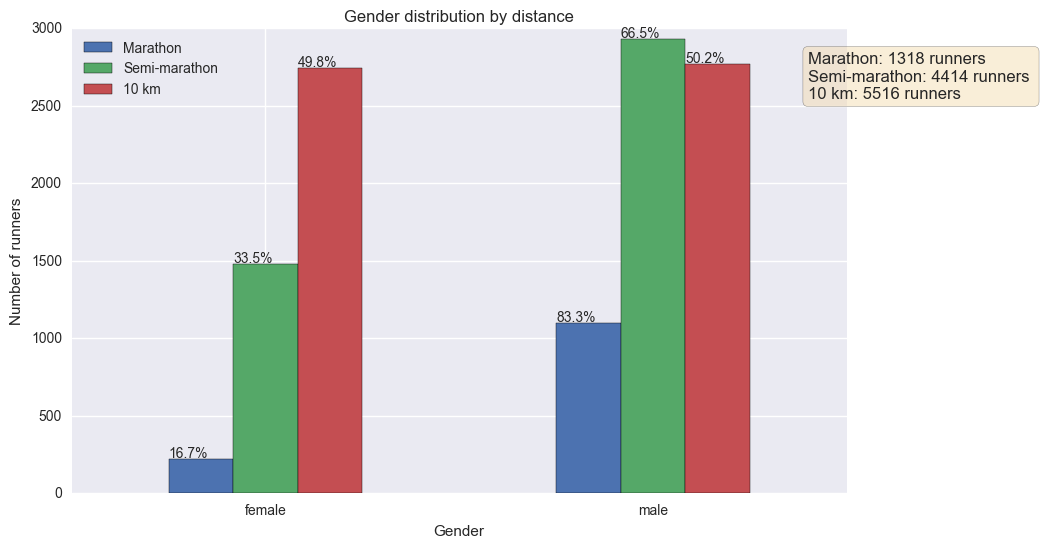

In [20]:
lausanne_2016_utils.plot_gender_distribution_according_to_running_type(lausanne_marathon_2016_10km, lausanne_marathon_2016_21km, lausanne_marathon_2016_42km)

We also see an interesting thing is that for 10 km running, distribution between male and female runners is similar, while for semi-marathon and marathon, we observe a clear difference between the repartition! According to the new direction of the Lausanne Marathon, there is a reason behind this observation.

> "Women don't even dare start the race unless they are totaly sure about mastering the distance, unlike men who sometimes finish completely exhausted.”
>
> Source: <a href="https://www.rts.ch/sport/athletisme/1258113-le-marathon-de-lausanne-change-dorientation.html">RTSSport (FR)</a>

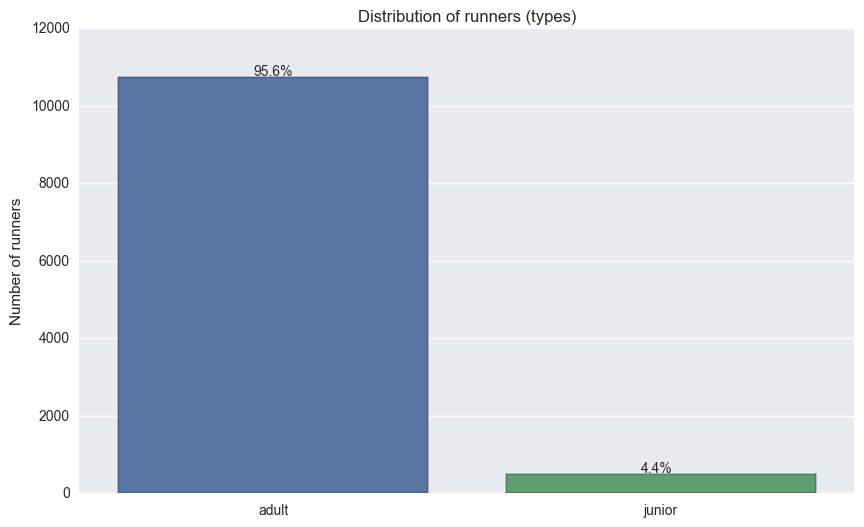

In [21]:
lausanne_2016_utils.plot_distribution_between_adults_and_juniors(lausanne_marathon_2016_cleaned)

Not surprinsingly, very minor part of runners were young runners in Lausanne Marathon of 2016. Indeed, these runnings ask a lot of effort and are very difficult for juniors runners.

## Demographic study

In this part, we plan to focus on age of runners, but also the place from which they come.

We first display the age distribution of runners in the marathon 2016 of Lausanne.

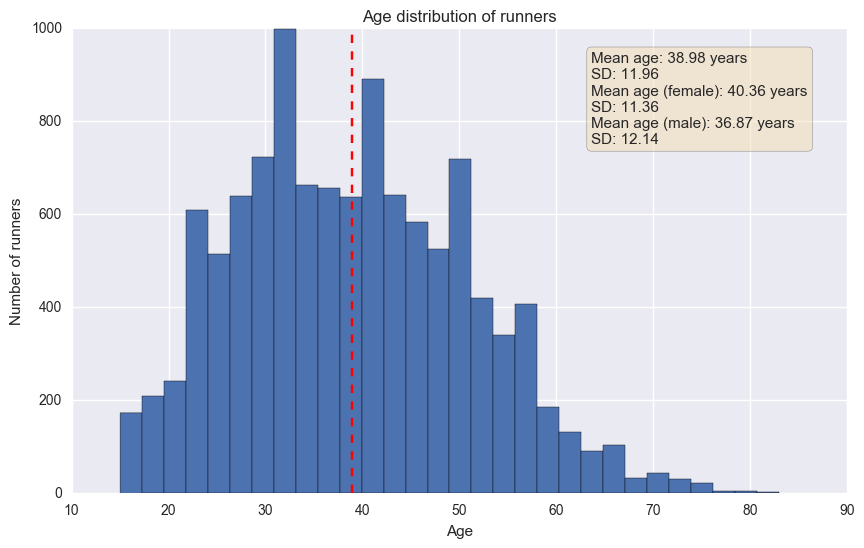

In [22]:
lausanne_2016_utils.plot_age_distribution(lausanne_marathon_2016_cleaned)

We can notice that, globally, the average age of runners is 39 years. We also observe the conclusion we previously made (i.e. male runners are younger than female ones as women wait before trying to participate to a semi-marathon or a marathon).

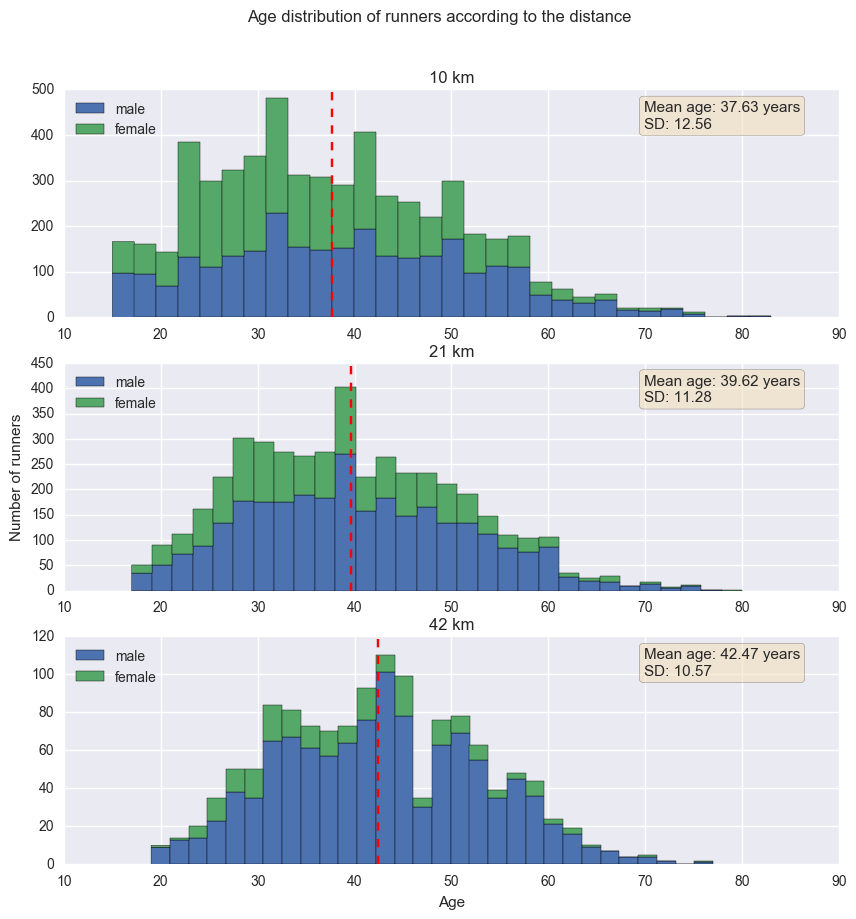

In [23]:
fig = plt.figure()
fig.tight_layout
fig.set_size_inches(10, 10)
fig.suptitle('Age distribution of runners according to the distance', fontsize=12)
lausanne_2016_utils.plot_distribution_age_distance(fig, lausanne_marathon_2016_10km, '10 km', 311)
lausanne_2016_utils.plot_distribution_age_distance(fig, lausanne_marathon_2016_21km, '21 km', 312)
lausanne_2016_utils.plot_distribution_age_distance(fig, lausanne_marathon_2016_42km, '42 km', 313)

Here, the important fact is that average age of runners tends to increase when number of kilometers of a runnings is increasing. This can be explained by the fact that it takes time before mastering such races like semi-marathons and marathons.

### Performance according to age of participants

#### Overall analysis

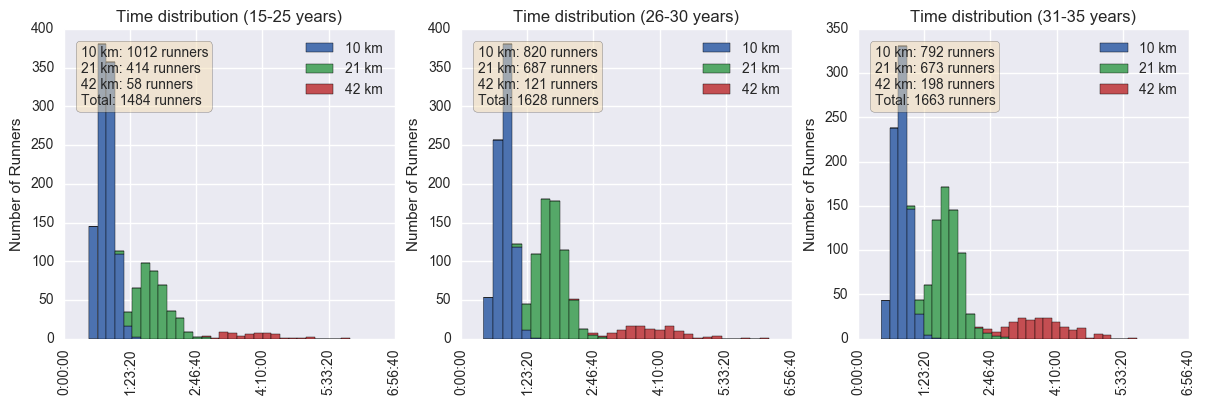

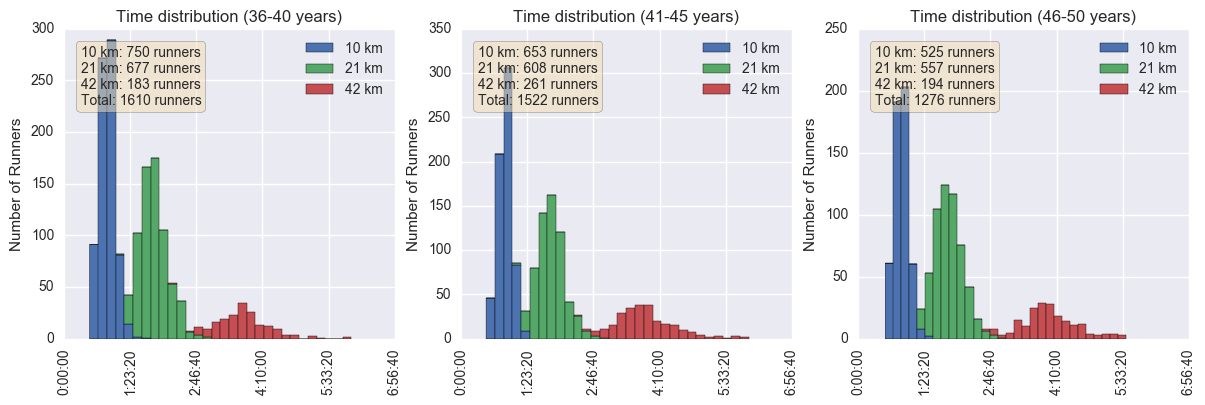

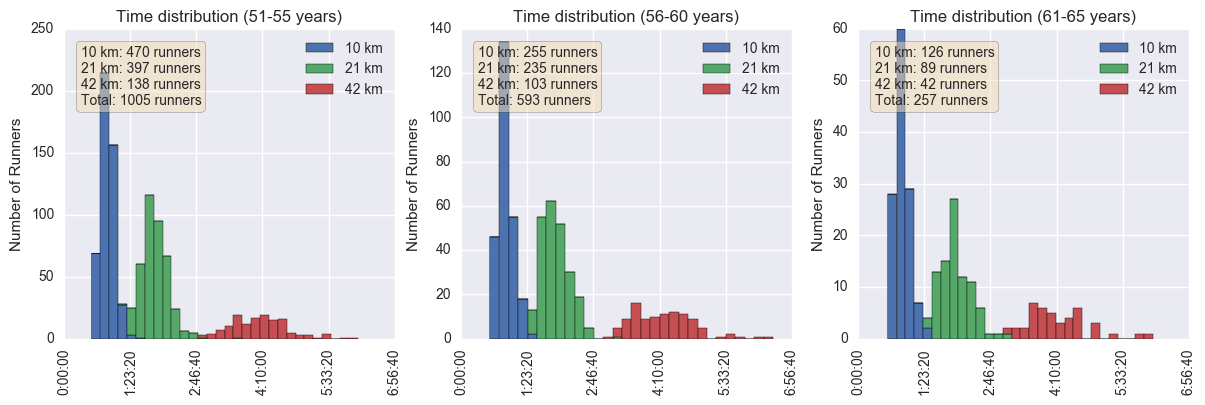

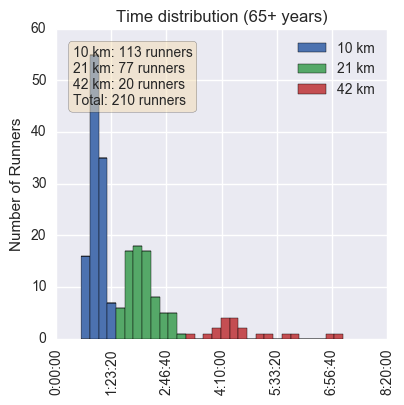

In [24]:
lausanne_2016_utils.plot_time_distribution_by_age(lausanne_marathon_2016_cleaned, 'age category')

#### Performance for 10 km running

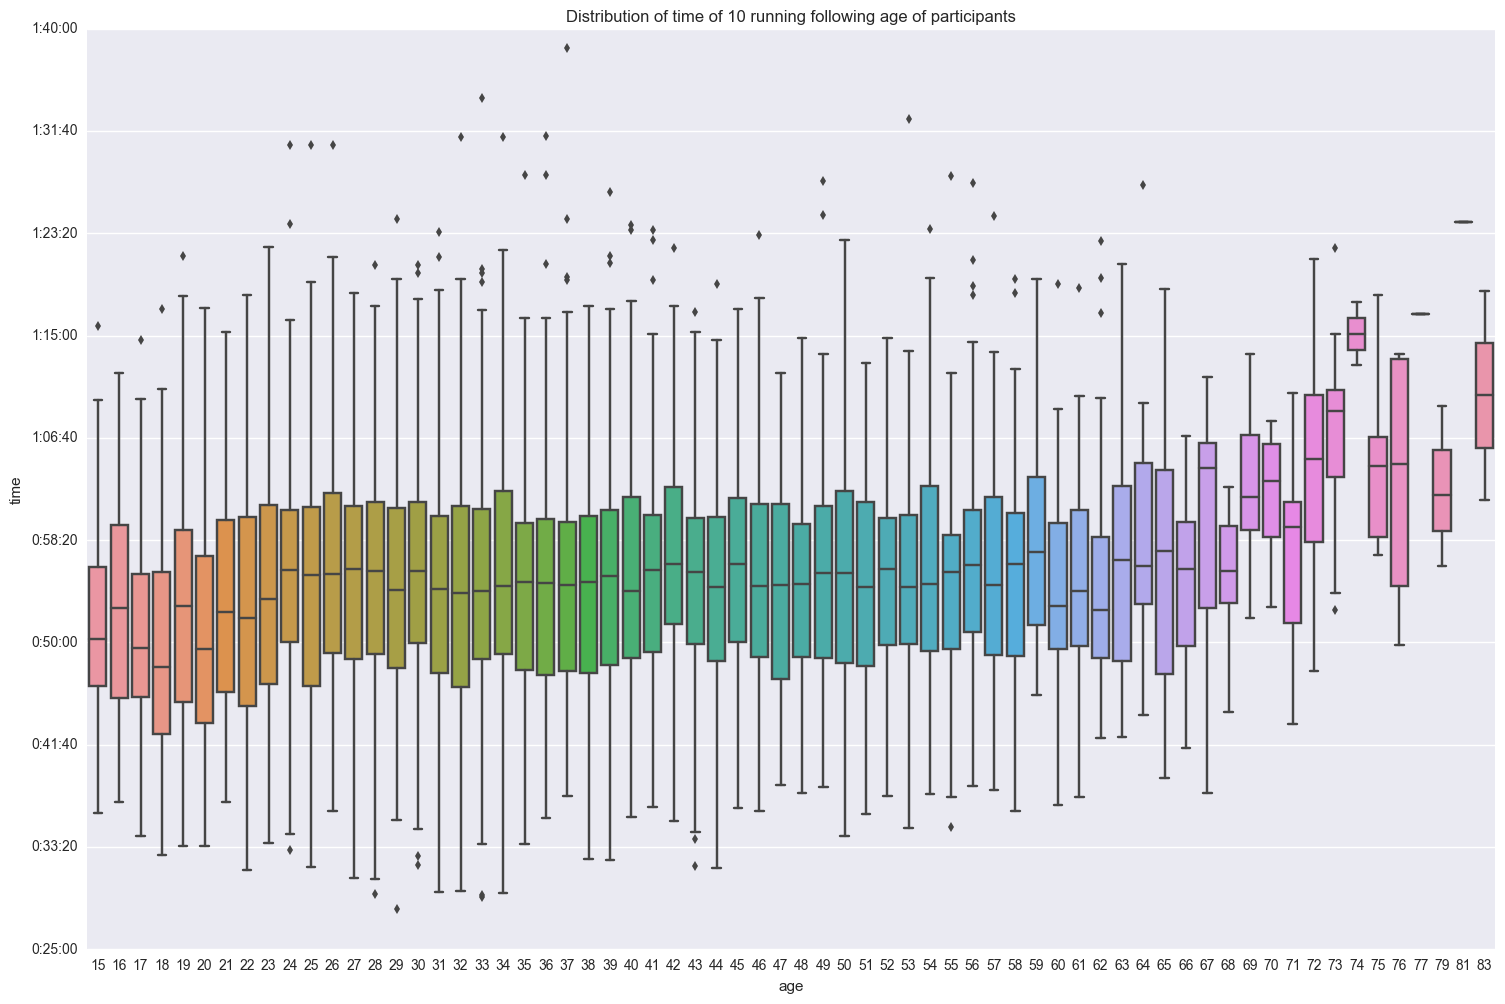

In [25]:
lausanne_2016_utils.plot_performance_according_to_running_type(lausanne_marathon_2016_10km, 10, 'age', size=10, aspect=1.5)

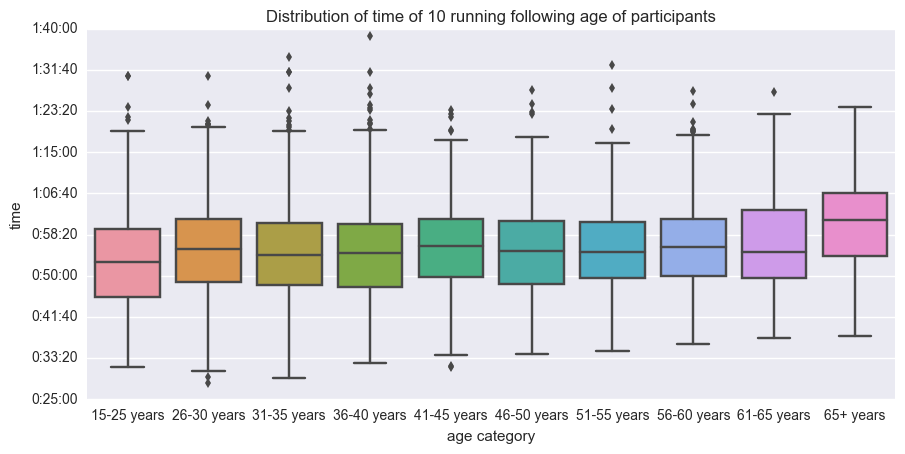

In [26]:
lausanne_2016_utils.plot_performance_according_to_running_type(lausanne_marathon_2016_10km, 10, 'age category')

#### Performance for demi-marathon

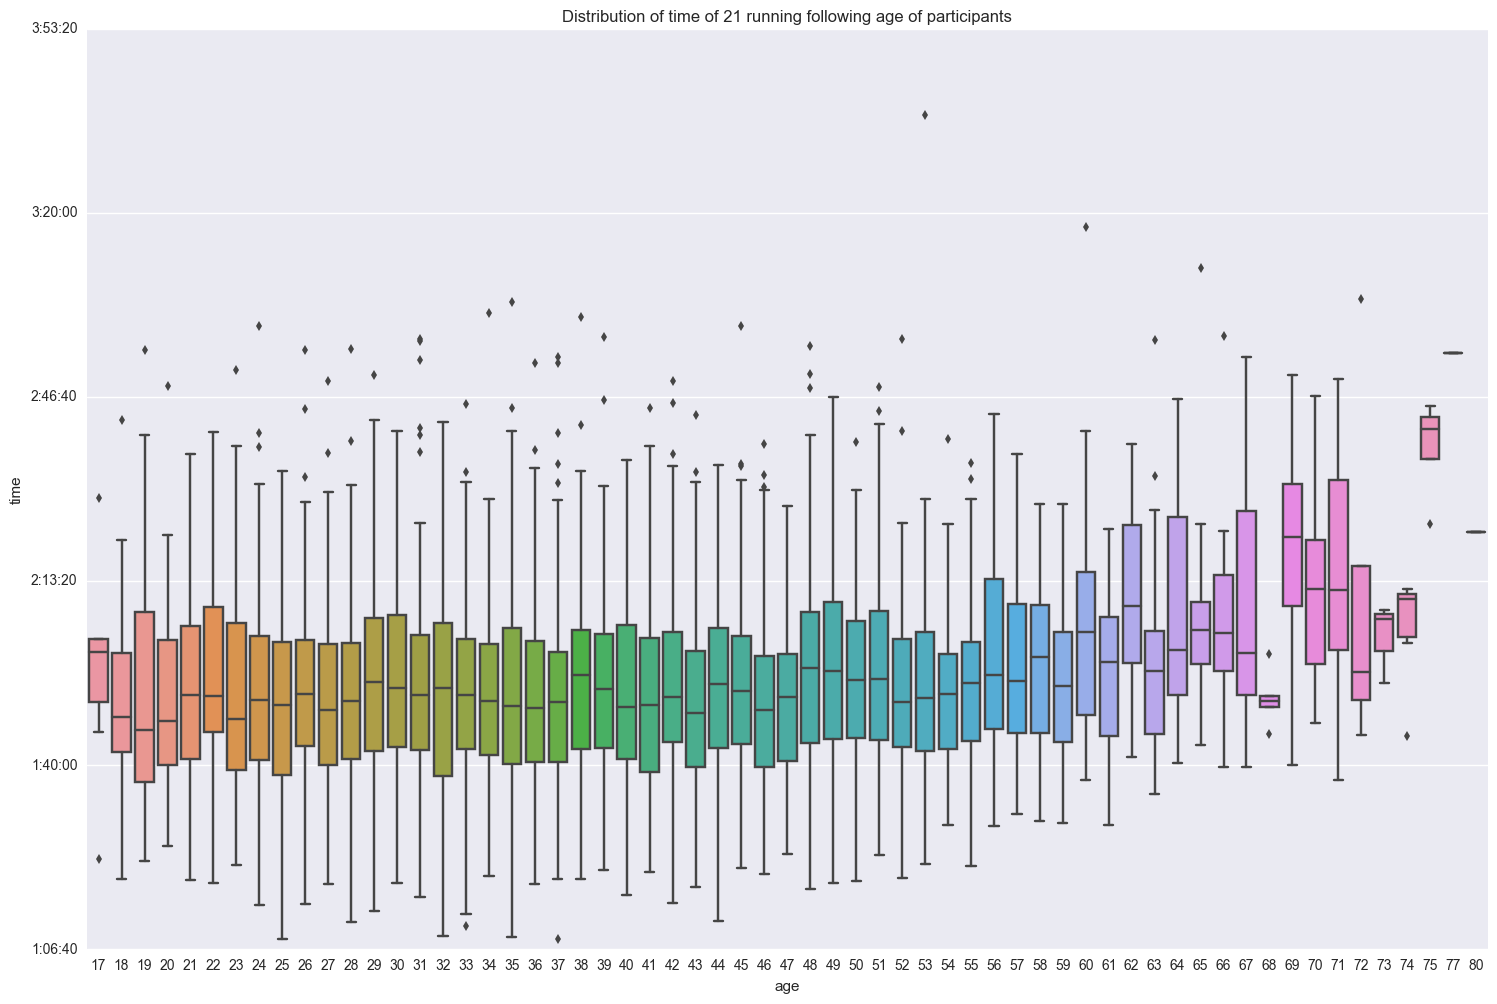

In [27]:
lausanne_2016_utils.plot_performance_according_to_running_type(lausanne_marathon_2016_21km, 21, 'age', size=10, aspect=1.5)

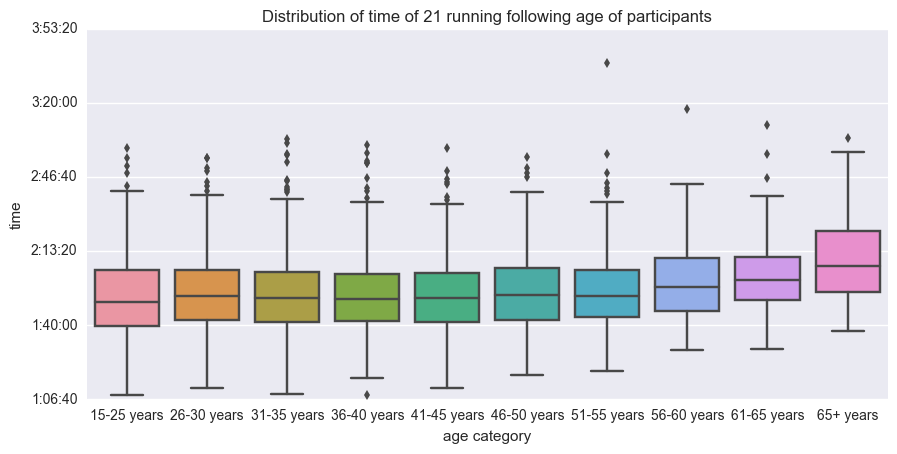

In [28]:
lausanne_2016_utils.plot_performance_according_to_running_type(lausanne_marathon_2016_21km, 21, 'age category')

#### Performance for marathon

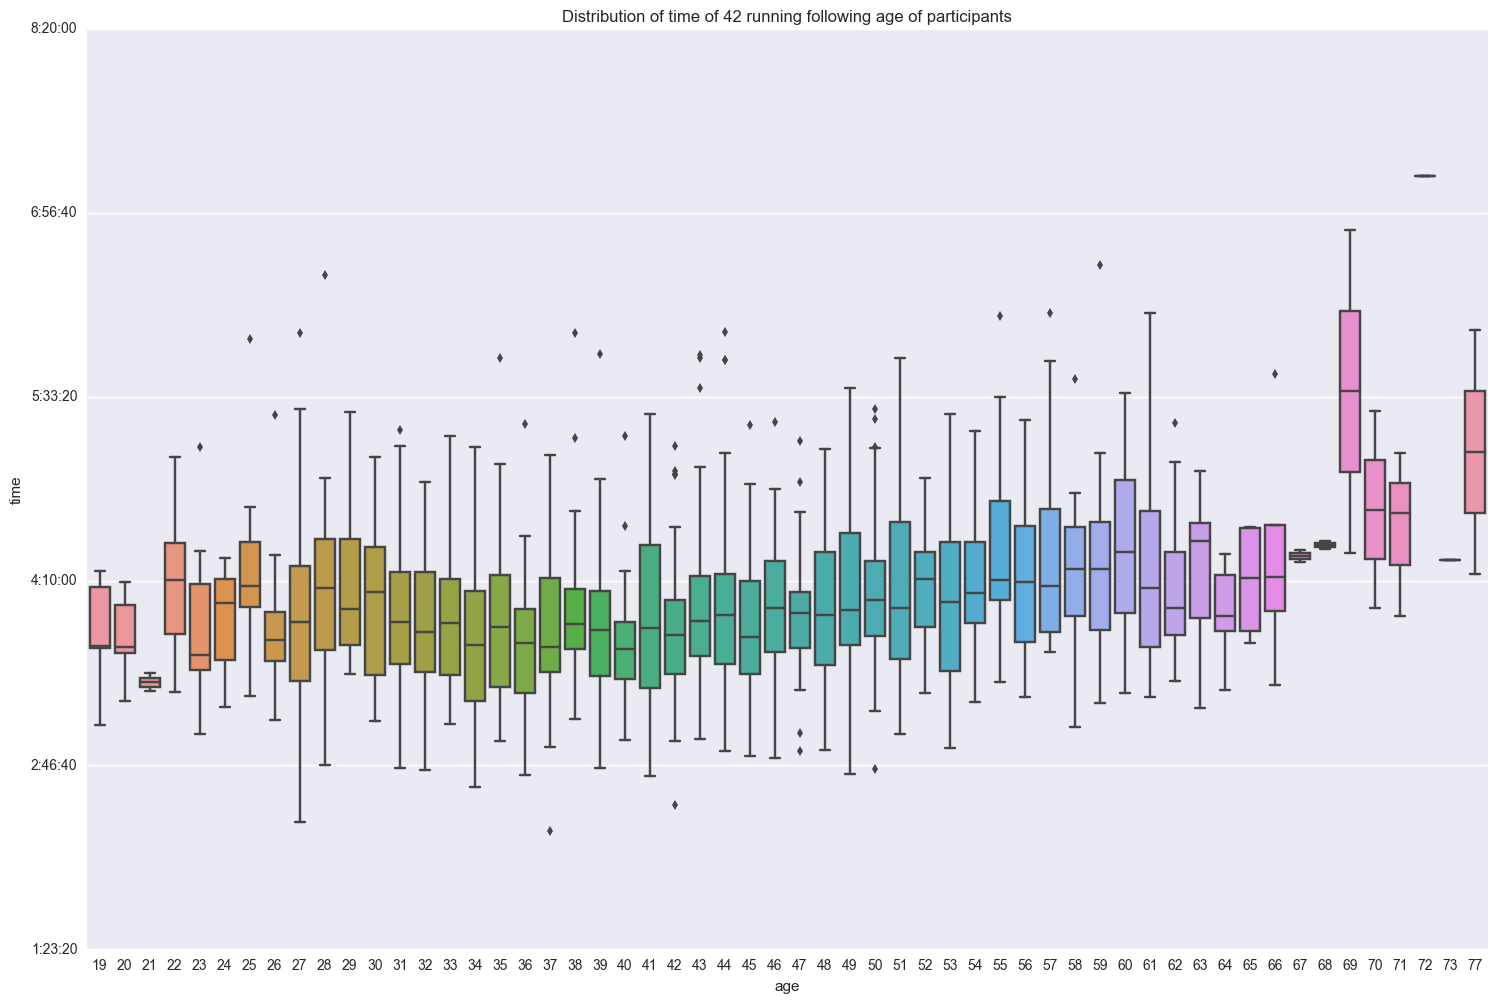

In [29]:
lausanne_2016_utils.plot_performance_according_to_running_type(lausanne_marathon_2016_42km, 42, 'age', size=10, aspect=1.5)

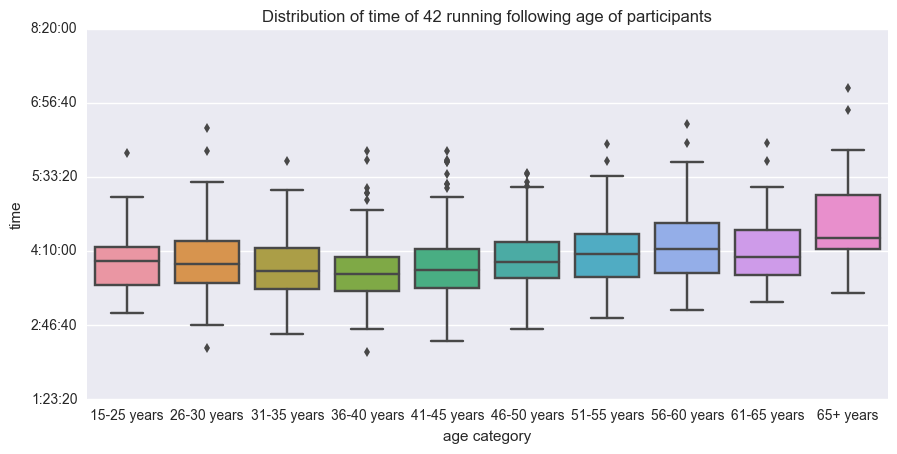

In [30]:
lausanne_2016_utils.plot_performance_according_to_running_type(lausanne_marathon_2016_42km, 42, 'age category')

#### Analysis of results

Globally, we observe more real differences at the extremes. But are these differences significant? We decide to compute ANOVA and Tukey HSD to verify it.

In [31]:
results_10km = study_utils.compute_anova_and_tukey_hsd(lausanne_marathon_2016_10km, 'age category', 'time')
print('F value: ' + str(results_10km['f_value']) + '\nP value: ' + str(results_10km['p_value']) + '\n')
results_10km['tukey_hsd'].rename(columns=lambda x: x.strip(), inplace=True)
results_10km['tukey_hsd'].set_index(['group1', 'group2'])

F value: 10.9576688214
P value: 4.36331120016e-17



meandiff     lower     upper  reject
group1      group2                                           
15-25 years 26-30 years  117.2616   32.6283  201.8948  True  
            31-35 years   88.0898    2.6341  173.5454  True  
            36-40 years  111.7553   24.9677  198.5429  True  
            41-45 years  157.4489   67.0349  247.8629  True  
            46-50 years  112.5583   15.6765  209.4402  True  
            51-55 years  126.0221   25.4772  226.5671  True  
            56-60 years  199.3958   73.1830  325.6086  True  
            61-65 years  199.0383   28.8731  369.2036  True  
            65+ years    470.0417  291.3838  648.6996  True  
26-30 years 31-35 years  -29.1718 -118.9123   60.5687  False 
            36-40 years   -5.5063  -96.5160   85.5034  False 
            41-45 years   40.1873  -54.2869  134.6615  False 
            46-50 years   -4.7032 -105.3848   95.9783  False 
            51-55 years    8.7606  -95.4506  112.9718  False 
            56-60 years   82.1342  -47.0182  211.2866  False 
            61-65 years   81.7768  -90.5802  254.1337  False 
            65+ years    352.7801  172.0336  533.5267  True  
31-35 years 36-40 years   23.6655  -68.1094  115.4405  False 
            41-45 years   69.3592  -25.8525  164.5708  False 
            46-50 years   24.4686  -76.9053  125.8425  False 
            51-55 years   37.9324  -66.9478  142.8126  False 
            56-60 years  111.3060  -18.3868  240.9989  False 
            61-65 years  110.9486  -61.8137  283.7108  False 
            65+ years    381.9520  200.8188  563.0851  True  
36-40 years 41-45 years   45.6936  -50.7153  142.1025  False 
            46-50 years    0.8030 -101.6961  103.3022  False 
            51-55 years   14.2668  -91.7014  120.2351  False 
            56-60 years   87.6405  -42.9338  218.2148  False 
            61-65 years   87.2830  -86.1419  260.7080  False 
            65+ years    358.2864  176.5211  540.0517  True  
41-45 years 46-50 years  -44.8906 -150.4779   60.6968  False 
            51-55 years  -31.4268 -140.3849   77.5314  False 
            56-60 years   41.9469  -91.0654  174.9591  False 
            61-65 years   41.5894 -133.6784  216.8573  False 
            65+ years    312.5928  129.0684  496.1173  True  
46-50 years 51-55 years   13.4638 -100.9184  127.8460  False 
            56-60 years   86.8374  -50.6532  224.3280  False 
            61-65 years   86.4800  -92.2103  265.1703  False 
            65+ years    357.4834  170.6877  544.2791  True  
51-55 years 56-60 years   73.3736  -66.7222  213.4695  False 
            61-65 years   73.0162 -107.6864  253.7188  False 
            65+ years    344.0196  155.2980  532.7411  True  
56-60 years 61-65 years   -0.3574 -196.5048  195.7900  False 
            65+ years    270.6459   67.0871  474.2048  True  
61-65 years 65+ years    271.0034   37.6308  504.3760  True

In [32]:
results_21km = study_utils.compute_anova_and_tukey_hsd(lausanne_marathon_2016_21km, 'age category', 'time')
print('F value: ' + str(results_21km['f_value']) + '\nP value: ' + str(results_21km['p_value']) + '\n')
results_21km['tukey_hsd'].rename(columns=lambda x: x.strip(), inplace=True)
results_21km['tukey_hsd'].set_index(['group1', 'group2'])

F value: 13.1462717114
P value: 5.89701883835e-21



meandiff     lower      upper  reject
group1      group2                                             
15-25 years 26-30 years    41.5578 -164.4656   247.5812  False 
            31-35 years   -11.0349 -217.8625   195.7927  False 
            36-40 years    17.9740 -188.6207   224.5688  False 
            41-45 years    -2.9173 -213.9137   208.0790  False 
            46-50 years    82.0283 -132.8454   296.9019  False 
            51-55 years    66.3169 -166.2866   298.9205  False 
            56-60 years   384.4849  114.0333   654.9366  True  
            61-65 years   598.5031  211.6107   985.3956  True  
            65+ years    1018.5976  607.6403  1429.5548  True  
26-30 years 31-35 years   -52.5927 -232.1839   126.9984  False 
            36-40 years   -23.5838 -202.9067   155.7392  False 
            41-45 years   -44.4752 -228.8519   139.9016  False 
            46-50 years    40.4704 -148.3311   229.2720  False 
            51-55 years    24.7591 -183.9985   233.5168  False 
            56-60 years   342.9271   92.6884   593.1659  True  
            61-65 years   556.9453  183.9023   929.9883  True  
            65+ years     977.0397  579.0936  1374.9859  True  
31-35 years 36-40 years    29.0090 -151.2374   209.2553  False 
            41-45 years     8.1176 -177.1573   193.3925  False 
            46-50 years    93.0632  -96.6156   282.7420  False 
            51-55 years    77.3519 -132.1995   286.9032  False 
            56-60 years   395.5199  144.6186   646.4211  True  
            61-65 years   609.5381  236.0503   983.0258  True  
            65+ years    1029.6325  631.2694  1427.9956  True  
36-40 years 41-45 years   -20.8914 -205.9063   164.1236  False 
            46-50 years    64.0542 -125.3707   253.4791  False 
            51-55 years    48.3429 -160.9786   257.6645  False 
            56-60 years   366.5109  115.8015   617.2203  True  
            61-65 years   580.5291  207.1703   953.8880  True  
            65+ years    1000.6235  602.3812  1398.8658  True  
41-45 years 46-50 years    84.9456 -109.2704   279.1616  False 
            51-55 years    69.2343 -144.4327   282.9013  False 
            56-60 years   387.4023  133.0536   641.7509  True  
            61-65 years   601.4205  225.6082   977.2328  True  
            65+ years    1021.5149  620.9716  1422.0583  True  
46-50 years 51-55 years   -15.7113 -233.2080   201.7854  False 
            56-60 years   302.4567   44.8824   560.0309  True  
            61-65 years   516.4749  138.4721   894.4777  True  
            65+ years     936.5693  533.9700  1339.1686  True  
51-55 years 56-60 years   318.1680   45.6277   590.7083  True  
            61-65 years   532.1862  143.8309   920.5415  True  
            65+ years     952.2806  539.9459  1364.6154  True  
56-60 years 61-65 years   214.0182 -198.1220   626.1584  False 
            65+ years     634.1126  199.3028  1068.9225  True  
61-65 years 65+ years     420.0944  -95.2708   935.4596  False

In [33]:
results_42km = study_utils.compute_anova_and_tukey_hsd(lausanne_marathon_2016_42km, 'age category', 'time')
print('F value: ' + str(results_42km['f_value']) + '\nP value: ' + str(results_42km['p_value']) + '\n')
results_42km['tukey_hsd'].rename(columns=lambda x: x.strip(), inplace=True)
results_42km['tukey_hsd'].set_index(['group1', 'group2'])

F value: 11.5770412514
P value: 1.23630215228e-17



meandiff      lower      upper  reject
group1      group2                                              
15-25 years 26-30 years   132.1337  -979.8138  1244.0811  False 
            31-35 years  -429.3595 -1468.8914   610.1725  False 
            36-40 years  -653.1896 -1702.3295   395.9504  False 
            41-45 years  -273.2375 -1283.9452   737.4701  False 
            46-50 years   185.1530  -856.8041  1227.1102  False 
            51-55 years   567.6432  -521.8862  1657.1725  False 
            56-60 years  1061.9956   -81.0005  2204.9918  False 
            61-65 years   835.2964  -575.3748  2245.9676  False 
            65+ years    2937.9845  1132.5458  4743.4232  True  
26-30 years 31-35 years  -561.4931 -1364.8981   241.9118  False 
            36-40 years  -785.3232 -1601.1219    30.4755  False 
            41-45 years  -405.3712 -1171.1145   360.3721  False 
            46-50 years    53.0194  -753.5211   859.5599  False 
            51-55 years   435.5095  -431.6163  1302.6353  False 
            56-60 years   929.8620    -3.5581  1863.2821  False 
            61-65 years   703.1627  -543.7639  1950.0894  False 
            65+ years    2805.8508  1125.2433  4486.4584  True  
31-35 years 36-40 years  -223.8301  -937.7817   490.1215  False 
            41-45 years   156.1219  -500.0505   812.2943  False 
            46-50 years   614.5125   -88.8416  1317.8666  False 
            51-55 years   997.0026   224.9233  1769.0820  True  
            56-60 years  1491.3551   645.4990  2337.2112  True  
            61-65 years  1264.6558    81.8517  2447.4600  True  
            65+ years    3367.3439  1733.7463  5000.9416  True  
36-40 years 41-45 years   379.9520  -291.3379  1051.2419  False 
            46-50 years   838.3426   120.8644  1555.8208  True  
            51-55 years  1220.8327   435.8649  2005.8006  True  
            56-60 years  1715.1852   857.5486  2572.8218  True  
            61-65 years  1488.4859   297.2288  2679.7431  True  
            65+ years    3591.1740  1951.4456  5230.9024  True  
41-45 years 46-50 years   458.3906  -201.6171  1118.3983  False 
            51-55 years   840.8807   108.0712  1573.6902  True  
            56-60 years  1335.2332   525.0630  2145.4034  True  
            61-65 years  1108.5339   -49.0190  2266.0869  False 
            65+ years    3211.2220  1595.8136  4826.6305  True  
46-50 years 51-55 years   382.4901  -392.8514  1157.8317  False 
            56-60 years   876.8426    28.0078  1725.6774  True  
            61-65 years   650.1433  -534.7928  1835.0795  False 
            65+ years    2752.8314  1117.6895  4387.9734  True  
51-55 years 56-60 years   494.3525  -412.2456  1400.9506  False 
            61-65 years   267.6532  -959.3240  1494.6305  False 
            65+ years    2370.3413   704.4815  4036.2011  True  
56-60 years 61-65 years  -226.6993 -1501.3910  1047.9925  False 
            65+ years    1875.9888   174.6791  3577.2986  True  
61-65 years 65+ years    2102.6881   211.1258  3994.2504  True

In all the cases, p value is extremly low. This means that we can reject null hypothesis H0 and conclude safely that there are significant differences between age categories!

## Effective performance according to BIB number

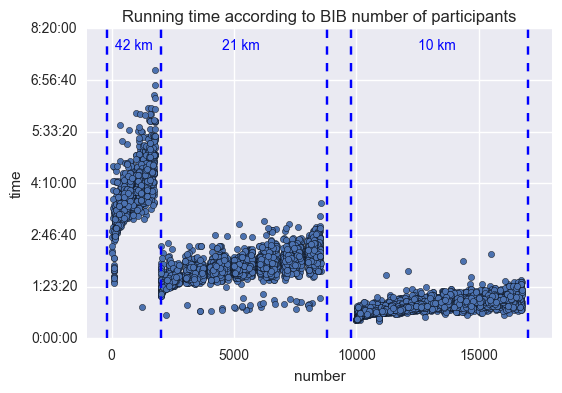

In [34]:
lausanne_2016_utils.plot_time_distribution_by_bib_numbers(lausanne_marathon_2016_cleaned)

We can recognize three major patterns following the BIB number of participants. Indeed, for each subdivisions, the higher the BIB number is, the lower the performance time is, globally.

Notice that BIB numbers are given by the organizators of Lausanne Marathon, and as we can read on <a href="http://fr.lausanne-marathon.com/inscription/inscriptions/inscription-online/">the official website</a>, each participant is asked to indicate his "estimated time of running for the attribution of start blocks", in oder to categorize the runners accordingly.

## Study by sex

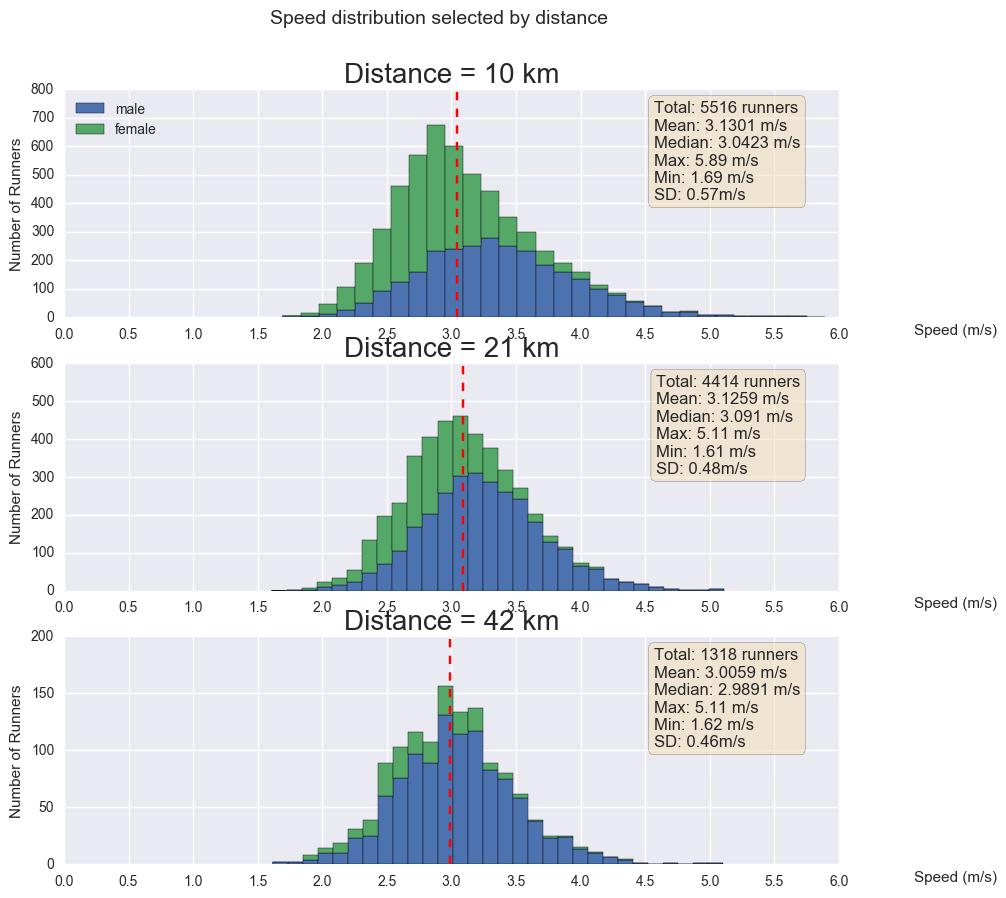

In [35]:
# Creation of figure
fig = plt.figure()
fig.tight_layout
fig.set_size_inches(10, 10)
fig.suptitle('Speed distribution selected by distance', fontsize=14)
lausanne_2016_utils.plot_speed_distribution_by_running(fig, lausanne_marathon_2016_10km, '10 km', 1, np.arange(0,900, 100))
lausanne_2016_utils.plot_speed_distribution_by_running(fig, lausanne_marathon_2016_21km, '21 km', 2, np.arange(0,700, 100))
lausanne_2016_utils.plot_speed_distribution_by_running(fig, lausanne_marathon_2016_42km, '42 km', 3, np.arange(0,250, 50))

As we can expect the fastest runners have made the 10 km, as the distance is shorter, the speed by kilometer can be greater.

But unexpectedly the average speed seems very close between runners despite the difference of the distance, in order to understand this phenomenon we need to go further in the study and study the past of runners.

### Statistical analysis

** Overview **

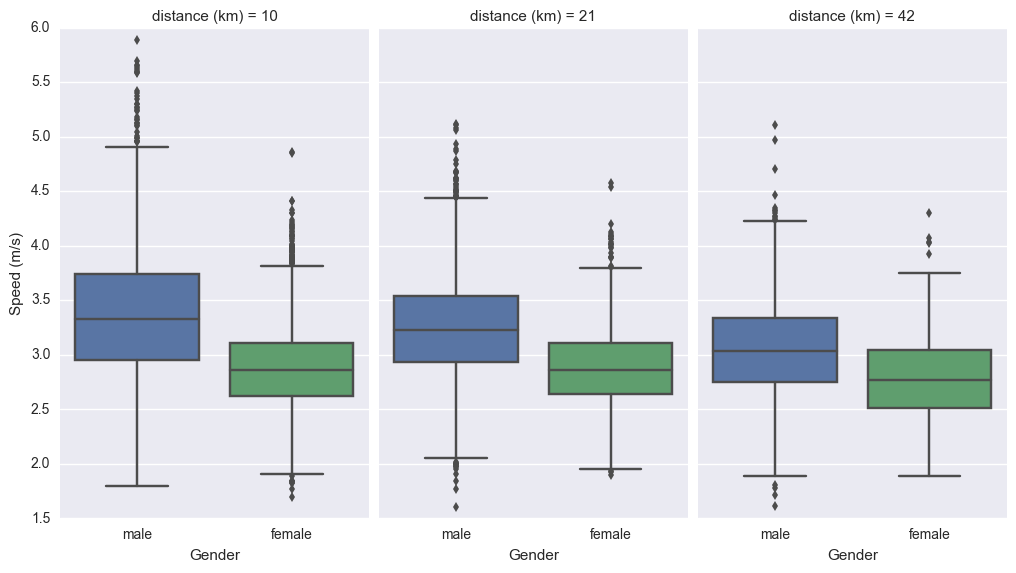

In [36]:
plot = sns.factorplot(data=lausanne_marathon_2016_cleaned, x='sex', y='Speed (m/s)', col = 'distance (km)', size=5, kind='box')
plot.set_xlabels('Gender')
plot.fig.set_size_inches(10, 6)

Following the boxplots, differences seem to be significant.

** 10 km running **

In [37]:
results_10km = study_utils.compute_anova_and_tukey_hsd(lausanne_marathon_2016_10km, 'sex', 'Speed (m/s)')
print('F value: ' + str(results_10km['f_value']) + '\nP value: ' + str(results_10km['p_value']) + '\n')
results_10km['tukey_hsd'].rename(columns=lambda x: x.strip(), inplace=True)
results_10km['tukey_hsd'].set_index(['group1', 'group2'])

F value: 1259.85300243
P value: 1.01333050347e-248



,,meandiff,lower,upper,reject
group1,group2,,,,
female,male,0.4899,0.4628,0.517,True


** Semi-marathon **

In [38]:
results_21km = study_utils.compute_anova_and_tukey_hsd(lausanne_marathon_2016_21km, 'sex', 'Speed (m/s)')
print('F value: ' + str(results_21km['f_value']) + '\nP value: ' + str(results_21km['p_value']) + '\n')
results_21km['tukey_hsd'].rename(columns=lambda x: x.strip(), inplace=True)
results_21km['tukey_hsd'].set_index(['group1', 'group2'])

F value: 671.355174951
P value: 6.55496134736e-138



,,meandiff,lower,upper,reject
group1,group2,,,,
female,male,0.3663,0.3385,0.394,True


** Marathon **

In [39]:
results_42km = study_utils.compute_anova_and_tukey_hsd(lausanne_marathon_2016_42km, 'sex', 'Speed (m/s)')
print('F value: ' + str(results_42km['f_value']) + '\nP value: ' + str(results_42km['p_value']) + '\n')
results_42km['tukey_hsd'].rename(columns=lambda x: x.strip(), inplace=True)
results_42km['tukey_hsd'].set_index(['group1', 'group2'])

F value: 61.5033216457
P value: 9.07714985087e-15



,,meandiff,lower,upper,reject
group1,group2,,,,
female,male,0.2616,0.1961,0.327,True


As we can see, no matter the running we consider, the difference between male and female is significant as we can reject H0 hypothesis. Notice that p-value is higher for the case of marathon, as the distribution seem to be more similar (see previous plots).

## Focus on teams and single runners

First, let's display the distribution of runners with and without teams.

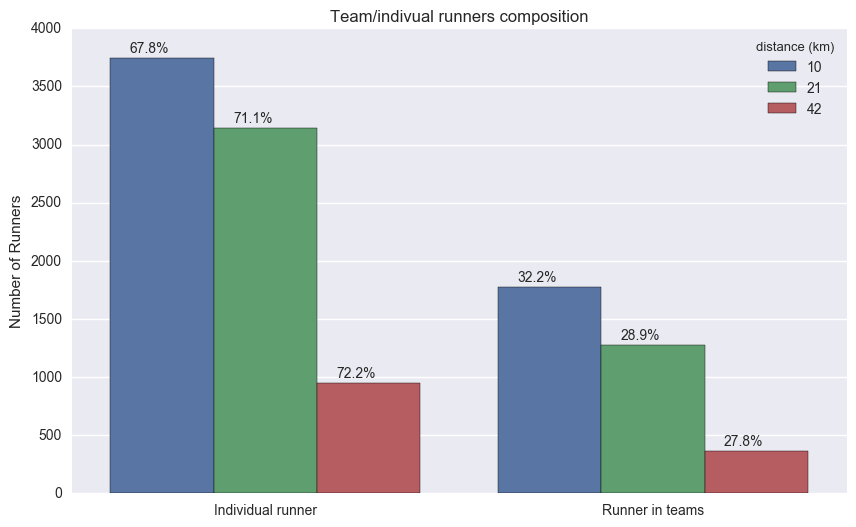

In [40]:
total_10 = len(lausanne_marathon_2016_10km)
total_21 = len(lausanne_marathon_2016_21km)
total_42 = len(lausanne_marathon_2016_42km)
lausanne_2016_utils.plot_distribution_team_individuals(lausanne_marathon_2016_cleaned, total_10, total_21, total_42)

The repartition individual/team seems quite equivalent between the different races offered by the event.
The teams are more present in the 10 km. The distance seems more appropriate for the teams, it's short enough to be a good challenge between beginner friends.

### Statistical analysis

Let's see if being in team has a real impact on the performance.

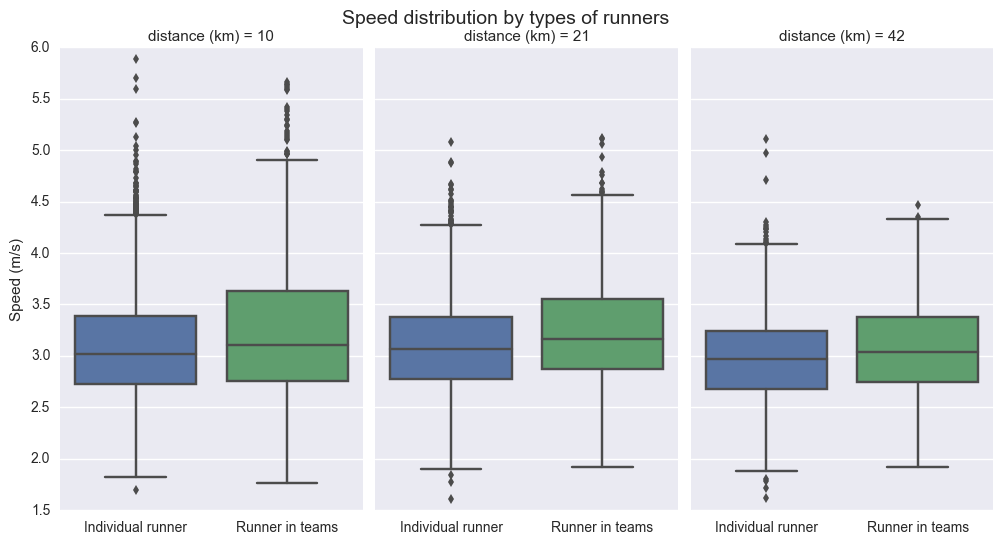

In [41]:
plot = sns.factorplot(data=lausanne_marathon_2016_cleaned, x='type_team', y='Speed (m/s)', col = 'distance (km)', kind='box')
plot.set_xlabels('')
plot.fig.suptitle('Speed distribution by types of runners', fontsize=14)
plot.fig.set_size_inches(10,6)

In [42]:
print(lausanne_2016_utils.display_information_speed(lausanne_marathon_2016_cleaned))

Median speed for 10Km race is for individual runners = 3.02206104563 m/s and for team runners = 3.10559006211 m/s


Actually the teams are better on average compared to individual runners, but the best performance comes from individual runners.
From the graph above, we can notice that for "average" people, to be part of a team seems to be a motivational factor, compared to excellent runners who prefer doing the race alone.

Running ANOVA permits us to draw the same conclusion, as showed in the following results. Notice that for the marathon, p value is higher than for the other races as medians tend to be similar between the two categories (runners with and without team), even if it is not sufficiently high to maintain H0 hypothesis (i.e. similar distributions).

In [43]:
results_teams_10km = study_utils.compute_anova_and_tukey_hsd(lausanne_marathon_2016_10km, 'type_team', 'Speed (m/s)')
print('F value: ' + str(results_teams_10km['f_value']) + '\nP value: ' + str(results_teams_10km['p_value']) + '\n')
results_teams_10km['tukey_hsd'].rename(columns=lambda x: x.strip(), inplace=True)
results_teams_10km['tukey_hsd'].set_index(['group1', 'group2'])

F value: 70.0639961898
P value: 7.20395185166e-17



,,meandiff,lower,upper,reject
group1,group2,,,,
Individual runner,Runner in teams,0.1362,0.1043,0.1681,True


In [44]:
results_teams_21km = study_utils.compute_anova_and_tukey_hsd(lausanne_marathon_2016_21km, 'type_team', 'Speed (m/s)')
print('F value: ' + str(results_teams_21km['f_value']) + '\nP value: ' + str(results_teams_21km['p_value']) + '\n')
results_teams_21km['tukey_hsd'].rename(columns=lambda x: x.strip(), inplace=True)
results_teams_21km['tukey_hsd'].set_index(['group1', 'group2'])

F value: 79.599228337
P value: 6.59735898554e-19



,,meandiff,lower,upper,reject
group1,group2,,,,
Individual runner,Runner in teams,0.1397,0.109,0.1704,True


In [45]:
results_teams_42km = study_utils.compute_anova_and_tukey_hsd(lausanne_marathon_2016_42km, 'type_team', 'Speed (m/s)')
print('F value: ' + str(results_teams_42km['f_value']) + '\nP value: ' + str(results_teams_42km['p_value']) + '\n')
results_teams_42km['tukey_hsd'].rename(columns=lambda x: x.strip(), inplace=True)
results_teams_42km['tukey_hsd'].set_index(['group1', 'group2'])

F value: 9.66344916911
P value: 0.00192000057478



,,meandiff,lower,upper,reject
group1,group2,,,,
Individual runner,Runner in teams,0.0879,0.0324,0.1434,True


In [46]:
team_selected = lausanne_marathon_2016_cleaned[lausanne_marathon_2016_cleaned['type_team'] == 'Runner in teams']
lausanne_marathon_2016_cleaned['time difference team'] = lausanne_marathon_2016_cleaned.apply(study_utils.compute_time_to_best_in_team,args=(team_selected,), axis=1)

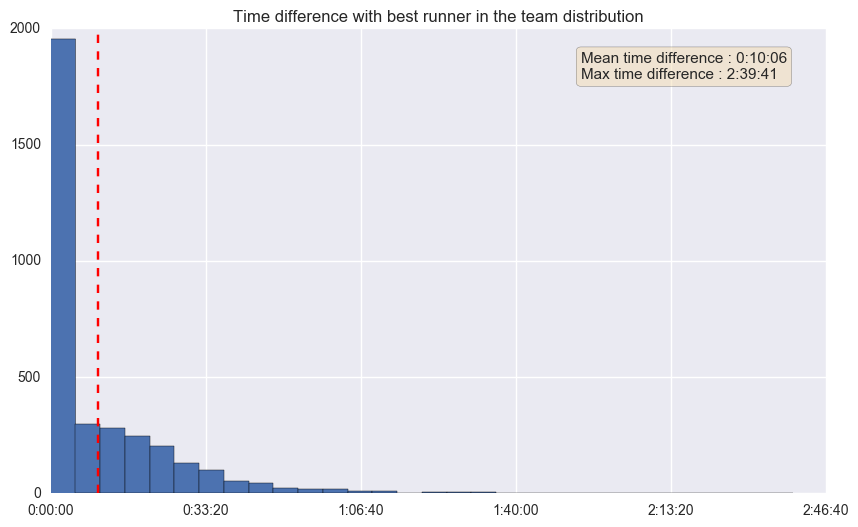

In [47]:
lausanne_marathon_team = lausanne_marathon_2016_cleaned[lausanne_marathon_2016_cleaned['type_team'] == 'Runner in teams'].copy()
lausanne_2016_utils.plot_time_difference_distribution(lausanne_marathon_team)

We observe that when runners are in team, they globally share similar performance (time's difference is between 0 and 5 minutes for the majority of runners). This indicates that similar people compose each team and they ran together, as we can expect it.

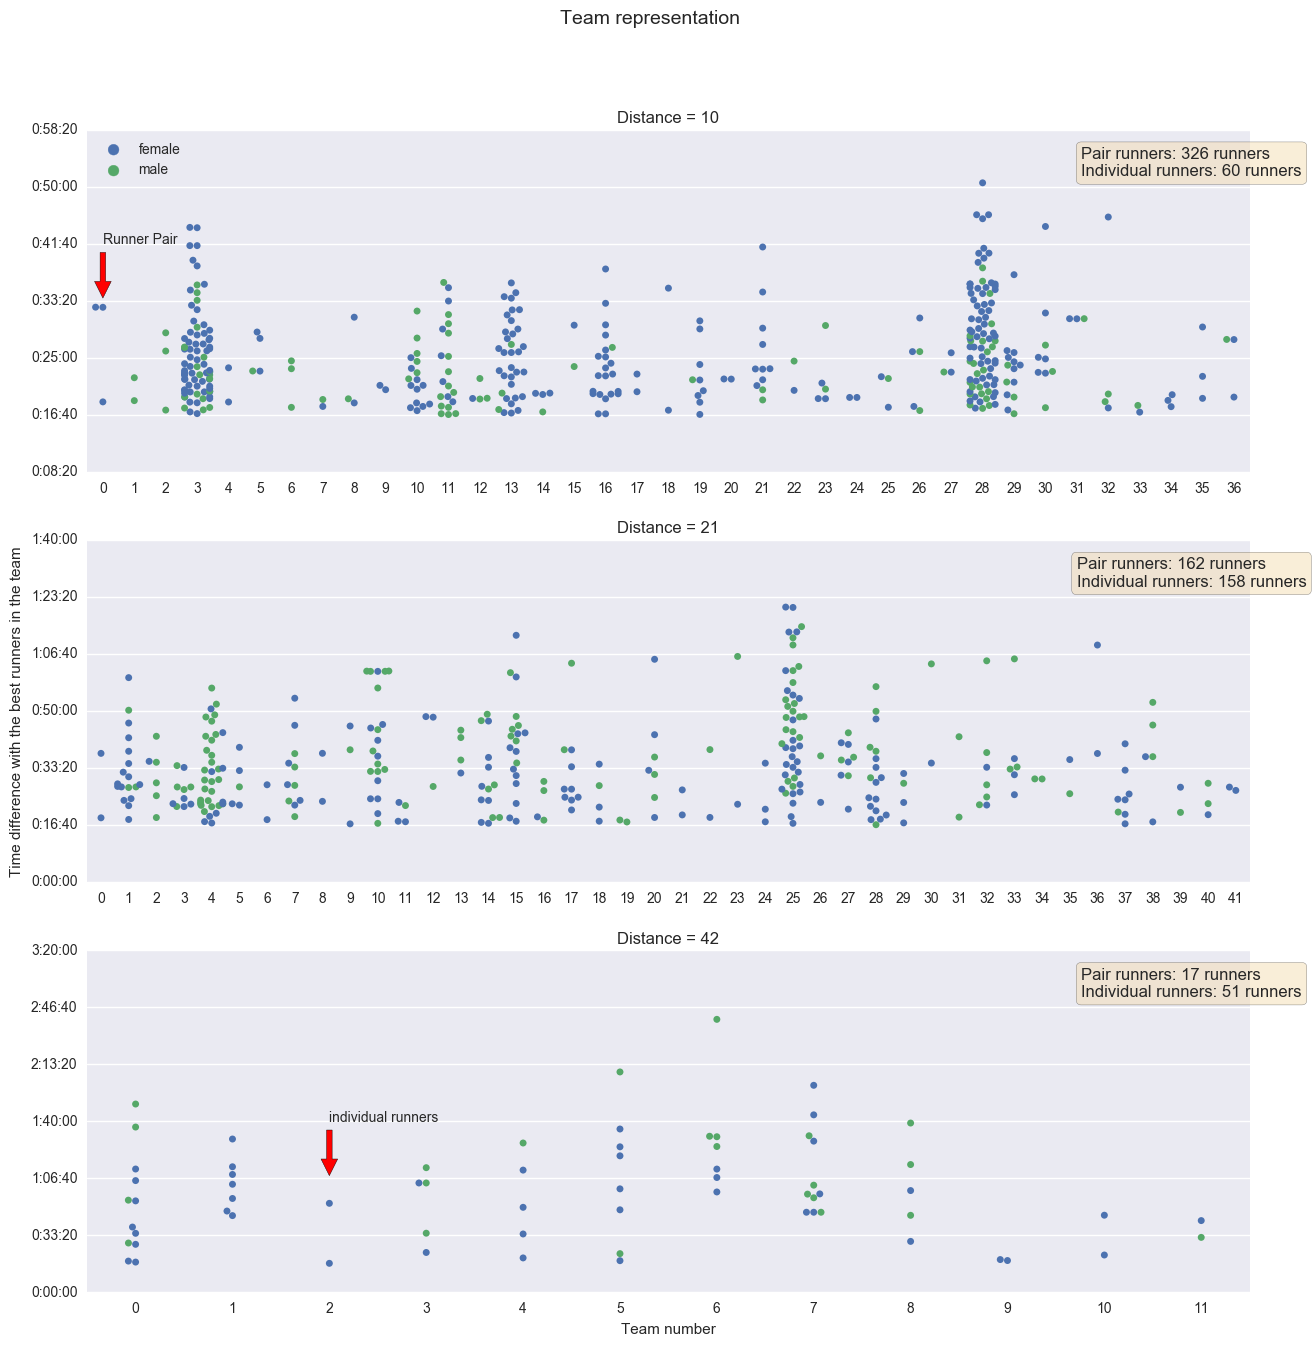

In [48]:
fig = plt.figure()
fig.tight_layout
fig.set_size_inches(15, 15)
fig.suptitle('Team representation', fontsize=14)
annotation_plot1 = [311,'Runner Pair',(0,2000), (0,2500)]
annotation_plot2 = [313,'individual runners',(2,4000), (2,6000)]
lausanne_2016_utils.plot_scatter_difference_time_number(fig, lausanne_marathon_2016_cleaned, 10, 311, annotation_plot1)
lausanne_2016_utils.plot_scatter_difference_time_number(fig, lausanne_marathon_2016_cleaned, 21, 312)
lausanne_2016_utils.plot_scatter_difference_time_number(fig, lausanne_marathon_2016_cleaned, 42, 313, annotation_plot2)

As we can noticed from the previous study most of pair/group of runner have finished the race together. In order to go futher we need to study the situation of those who finihsed later. (study above take runners wither a minimum late of 1000 seconds after the best runners in the team).

We have considered a pair/group runner if the distance time if weaker than 30sec. It is very  unlikely that any two runners would have the exact same start and end time (within 30 sec) unless they ran together, so these visual clusters should be very accurate in showing running pairs/groups.Based on the graph there are distinct differences in "belong to a team" in the difference race, Based on the graph the 10km seems to be the more solidary one, where most people in a team ran in pair/group (326 runners compared to 60 runners who have finished alone). The 21km had a half of runner who have ran in pair/group whereas the 42km seems the more individiual one where 51 runners finished alone compared to 17 runners in teams/groups. 42 km is a long distance, the challenge is often individual and often seen as personnal reward of long hour of training, this could explain the difference in type of runners belong to a team.